In [ ]:
## This version excludes CONTINUOUS Variables and the RFD variables AND _wHICH VARIABLES 3/27/2024 and con_max_consultorder_time/day and drg name
## 4/4/2024 Added QUINTILE variables
## 4/8/2024 Added QUINTILE varables by service
## 4/9/2024 Added more consult and imaging variables (e.g. ad,it order to consult order, admit order to imaging read)
## 4/11/2024 Added QUINTILE variables by service for the additional variables
# 06/12/2024: Added gender, added imaging_order_before_consult_order and consult_order_before_imaging order variables, excluded 290 patients in 2022, dropped raw race/insurance categories
# 06/14/2024: Removed quintiles
# 06/20/2024: Set seed for reproducibility
# 06/22/2024: Added sample size for validation
# 07/08/2024: Added labels

In [1]:
import pandas as pd
import numpy as np

#ML packages
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from feature_engine.discretisation import DecisionTreeDiscretiser
from sklearn.model_selection import GroupShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.calibration import calibration_curve

#XGBo
#https://github.com/liannewriting/YouTube-videos-public/blob/main/xgboost-python-tutorial-example/xgboost_python.ipynb
import xgboost as xgb
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
#hyperparameter values
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

#Feature Selection
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.encoding import OneHotEncoder
from feature_engine.selection import DropFeatures, DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.imputation import AddMissingIndicator
from feature_engine.outliers import Winsorizer
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import RareLabelEncoder

#Plotting Packages
import shap
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [12]:
def load_feature_lists(fp):
    features_los = pd.read_excel(fp)
    drop_list = features_los[features_los['type'] == 'drop']['col_name'].tolist()
    category_list = features_los[features_los['type'] == 'category']['col_name'].tolist()
    binary_list = features_los[features_los['type'] == 'binary']['col_name'].tolist()
    continuous_list = features_los[features_los['type'] == 'continuous']['col_name'].tolist()
    discrete_list = features_los[features_los['type'] == 'discrete']['col_name'].tolist()
    return drop_list, category_list, binary_list, continuous_list, discrete_list


In [14]:
def preprocess_and_split(df_filt, drop_list, category_list, binary_list, continuous_list):
    # Separate features and target variable
    X = df_filt.drop(['viz_outcome_prolonged_los_yn'], axis=1)
    y = df_filt['viz_outcome_prolonged_los_yn']

    # Convert variables to categorical
    X[binary_list] = X[binary_list].astype('category')
    X[category_list] = X[category_list].astype('category')

    # Drop specified columns
    continuous_list.remove("viz_age")  # Ensure "viz_age" is not dropped
    X = X.drop(columns=drop_list + continuous_list)

    # Reset index to ensure alignment during split
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    
    # Split the data by group shuffle split on 'PAT_MRN_ID' into train set and validation set
    gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
    train_ix, val_ix = next(gss.split(X, y, groups=X['pat_mrn_id']))
    
    # Select train and validation sets
    X_train = X.loc[train_ix].reset_index(drop=True)
    y_train = y.loc[train_ix].reset_index(drop=True)
    X_val = X.loc[val_ix].reset_index(drop=True)
    y_val = y.loc[val_ix].reset_index(drop=True)

    # Drop 'PAT_MRN_ID' and set 'PAT_ENC_CSN_ID' as index
    if 'pat_mrn_id' in X_train.columns:
        X_train = X_train.drop(['pat_mrn_id'], axis=1)
    if 'pat_mrn_id' in X_val.columns:
        X_val = X_val.drop(['pat_mrn_id'], axis=1)
    
    if 'pat_enc_csn_id' in X_train.columns:
        X_train.set_index('pat_enc_csn_id', inplace=True)
    if 'pat_enc_csn_id' in X_val.columns:
        X_val.set_index('pat_enc_csn_id', inplace=True)
    
    return X_train, X_val, y_train, y_val


In [18]:
def create_feature_preprocessing_pipeline(discrete_list, category_list, binary_list):
    """
    Create a feature preprocessing pipeline.
    
    Parameters:
    discrete_list (list): List of discrete variable names.
    category_list (list): List of categorical variable names.
    binary_list (list): List of binary variable names.
    
    Returns:
    Pipeline: A scikit-learn Pipeline object.
    """
    return Pipeline(steps=[
        ('arbitrary_number_imputer', ArbitraryNumberImputer(arbitrary_number=0, variables=discrete_list)),
        ('categorical_imputer', CategoricalImputer(variables=category_list)),
        ('binary_imputer', CategoricalImputer(fill_value='0', variables=binary_list)),
        ('rare_label_encoder', RareLabelEncoder(tol=0.01, n_categories=5, max_n_categories=10, variables=category_list)),
        ('one_hot_category', OneHotEncoder(variables=category_list)),
    ])

def create_feature_selection_pipeline():
    """
    Create a feature selection pipeline.
    
    Returns:
    Pipeline: A scikit-learn Pipeline object.
    """
    return Pipeline(steps=[
        ('drop_constant', DropConstantFeatures(tol=0.99)),
        ('drop_duplicates', DropDuplicateFeatures()),
        ('correlated_features', SmartCorrelatedSelection(
            method='pearson',
            threshold=0.9,
            selection_method='model_performance',
            estimator=xgb.XGBClassifier(random_state=0)
        ))
    ])

def preprocess_and_select_features(X_train, y_train, X_val, discrete_list, category_list, binary_list):
    """
    Preprocess and select features for training and validation sets.
    
    Parameters:
    X_train (DataFrame): Training feature set.
    y_train (Series): Training target variable.
    X_val (DataFrame): Validation feature set.
    discrete_list (list): List of discrete variable names.
    category_list (list): List of categorical variable names.
    binary_list (list): List of binary variable names.
    
    Returns:
    DataFrame, DataFrame: Preprocessed and selected training and validation feature sets.
    """
    # Create pipelines
    feature_preprocess_pipeline = create_feature_preprocessing_pipeline(discrete_list, category_list, binary_list)
    feature_selection_pipeline = create_feature_selection_pipeline()

    # Apply the preprocessing pipeline
    X_train_preprocessed = feature_preprocess_pipeline.fit_transform(X_train, y_train)
    X_val_preprocessed = feature_preprocess_pipeline.transform(X_val)

    # Apply the feature selection pipeline
    X_train_selected = feature_selection_pipeline.fit_transform(X_train_preprocessed, y_train)
    X_val_selected = feature_selection_pipeline.transform(X_val_preprocessed)

    return X_train_selected, X_val_selected

In [22]:
def create_estimators():
    return [
        ('encoder', TargetEncoder()),
        ('clf', XGBClassifier(random_state=8, verbosity=1))
    ]

def create_tuning_pipeline(estimators):
    return Pipeline(steps=estimators)

def define_search_space():
    return {
        'clf__max_depth': Integer(2, 8),
        'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
        'clf__subsample': Real(0.5, 1.0),
        'clf__colsample_bytree': Real(0.5, 1.0),
        'clf__colsample_bylevel': Real(0.5, 1.0),
        'clf__colsample_bynode': Real(0.5, 1.0),
        'clf__reg_alpha': Real(0.0, 10.0),
        'clf__reg_lambda': Real(0.0, 10.0),
        'clf__gamma': Real(0.0, 10.0)
    }

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, search_space, cv=3, n_iter=10, scoring='roc_auc'):
    # Fit the model
    y_train = y_train.set_index('pat_enc_csn_id')
    model.fit(X_train, y_train)

    # Print best estimator and best score
    print("Best estimator found:")
    print(model.best_estimator_)
    print("Best score found:")
    print(model.best_score_)

    # Evaluate on validation set
    y_val = y_val.set_index('pat_enc_csn_id')
    val_score = model.score(X_val, y_val)
    print(f"Validation score: {val_score}")

    return model

In [28]:
def plot_metrics(model_xgb, X_val_selected, y_val):
    # Predict probabilities
    y_probs = model_xgb.predict_proba(X_val_selected)
    y_probs_positive = y_probs[:, 1]

    # Extract y_test
    y_test = y_val['viz_outcome_prolonged_los_yn']

    # Plot metrics
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs_positive)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend()

    # Plot PR Curve
    precision, recall, _ = precision_recall_curve(y_test, y_probs_positive)
    pr_auc = auc(recall, precision)
    axes[1].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('PR Curve')
    axes[1].legend()

    # Plot Calibration Curve
    prob_true, prob_pred = calibration_curve(y_test, y_probs_positive, n_bins=10)
    axes[2].plot(prob_pred, prob_true, label='Calibration')
    axes[2].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
    axes[2].set_xlabel('Mean Predicted Probability')
    axes[2].set_ylabel('Fraction of Positives')
    axes[2].set_title('Calibration Curve')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

def plot_cm(model_xgb, X_val_selected, y_val):
    # Predict classes
    y_pred = model_xgb.predict(X_val_selected)

    # Generate confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Extract values for binary classification
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]

    # Calculate metrics
    top_row = tn + fp
    bot_row = fn + tp

    specificity_value = recall_score(y_val, y_pred, pos_label=0)
    sensitivity_value = recall_score(y_val, y_pred, pos_label=1)
    accuracy_value = accuracy_score(y_val, y_pred)
    precision_value = precision_score(y_val, y_pred)
    f1_value = f1_score(y_val, y_pred)

    # Print results
    print(f'Specificity : {specificity_value:.4f}')
    print(f'Sensitivity : {sensitivity_value:.4f}')
    print(f'Accuracy : {accuracy_value:.4f}')
    print(f'Precision : {precision_value:.4f}')
    print(f'F1 score : {f1_value:.4f}')

    print(f'Of {top_row} people who did not have a prolonged LOS, {tn} ({specificity_value:.2%}) were correctly classified.')
    print(f'Of {bot_row} people who did have a prolonged LOS, {tp} ({sensitivity_value:.2%}) were correctly classified.')


In [41]:
def save_load_data(X_train_selected, X_val_selected, train_fp, val_fp):
    # Save data
    X_train_selected.to_csv(train_fp)
    X_val_selected.to_csv(val_fp)
    
    # Load data
    X_train_selected = pd.read_csv(train_fp, index_col=[0])
    X_val_selected = pd.read_csv(val_fp, index_col=[0])
    
    return X_train_selected, X_val_selected


In [57]:
def train_xgb_model(X_train_selected, y_train, X_val_selected, y_val, feature_importance=None):
    # Set seeds for reproducibility
    np.random.seed(1)

    # Initialize XGBoost classifier
    clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
    
    # If feature importance is provided, clean and update the model's importance
    if feature_importance:
        # Clean feature names (remove whitespace)
        feature_importance_clean = {key.replace(' ', '_'): value for key, value in feature_importance.items()}
        
        # Update the model's importance
        clf_xgb.set_params(importance_type='weight', **feature_importance_clean)
    
    # Fit the classifier
    clf_xgb.fit(X_train_selected, 
                y_train['viz_outcome_prolonged_los_yn'], 
                verbose=True,
                early_stopping_rounds=10,
                eval_metric='aucpr',
                eval_set=[(X_val_selected, y_val['viz_outcome_prolonged_los_yn'])])
    
    return clf_xgb

In [49]:
def get_shap_plot(clf_xgb, X_val_selected):
    # Explain the model using SHAP
    explainer = shap.Explainer(clf_xgb)
    shap_values = explainer(X_val_selected)
    
    # Plot the SHAP values
    shap.plots.beeswarm(shap_values, max_display=30)
    
    # Create DataFrame of SHAP values
    shap_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
    
    # Calculate mean absolute SHAP values
    mean_abs_shap = np.abs(shap_df).mean(axis=0)
    
    # Get top 30 features by mean absolute SHAP value
    top_30_features = mean_abs_shap.sort_values(ascending=False).head(30)
    
    # Print top features
    for feature in top_30_features.index.tolist():
        print(feature)
    
    return shap_values

In [51]:
def rename_shap_features(shap_values, label_names_csv):
    # Load label names mapping from CSV
    lab_df = pd.read_csv(label_names_csv)
    
    # Create a dictionary mapping old names to new names
    new_feature_names_dict = pd.Series(lab_df.new_name.values, index=lab_df.old_name).to_dict()
    
    # Get current feature names from SHAP values
    current_feature_names = shap_values.feature_names
    
    # Update feature names in the SHAP values object
    new_feature_names = [new_feature_names_dict.get(name, name) for name in current_feature_names]
    shap_values.feature_names = new_feature_names
    
    return shap_values

In [ ]:
df_all = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/LOS/data/master_los.csv', index_col=[0])

In [ ]:
df_all.shape

In [ ]:
df_filt = df_all[df_all["viz_drg"]=="heart failure & shock w mcc"].copy()

In [ ]:
df_filt.shape

In [15]:
drop_list, category_list, binary_list, continuous_list, discrete_list = load_feature_lists('/gpfs/milgram/project/rtaylor/imc33/LOS/data/features_los.xlsx')

In [16]:
X_train, X_val, y_train, y_val= preprocess_and_split(df_filt, drop_list, category_list, binary_list, continuous_list)

In [19]:
X_train_selected, X_val_selected = preprocess_and_select_features(X_train, y_train, X_val, discrete_list, category_list, binary_list)

In [20]:
X_train_selected.shape

(1104, 437)

In [21]:
X_val_selected.shape

(265, 437)

In [29]:
# Define and create pipeline components
estimators = create_estimators()
tuning_pipeline = create_tuning_pipeline(estimators)
search_space = define_search_space()

# Train and evaluate the model
model_xgb = BayesSearchCV(tuning_pipeline, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8)
model_xgb = train_and_evaluate_model(model_xgb, X_train_selected, y_train, X_val_selected, y_val, search_space)

Best estimator found:
Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['thro_boarding_yn',
                                     'con_max_consult_order_to_sign_is_signer_ym_provider_yn',
                                     'con_max_consult_order_to_sign_is_signer_nemg_provider_yn',
                                     'con_max_consult_order_to_sign_is_signer_community_provider_yn',
                                     'icu_any_icu_yn'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0031574039841631043,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth

In [38]:
y_val = y_val.reset_index()

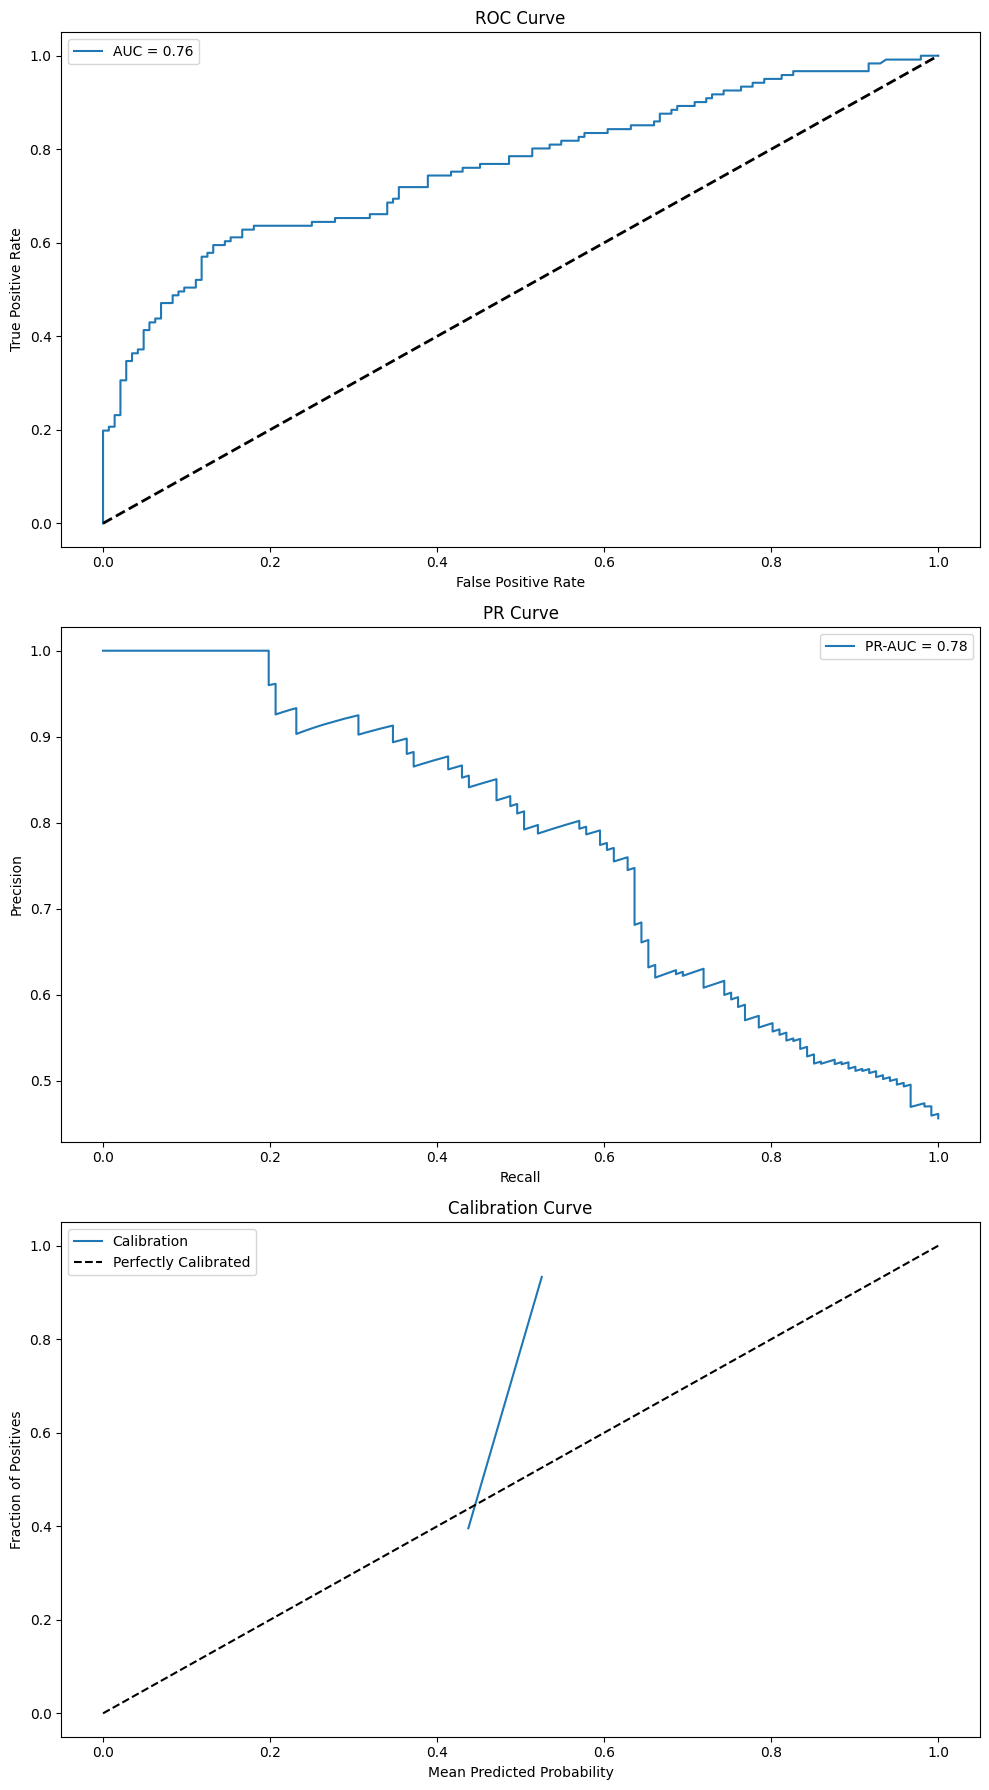

In [39]:
plot_metrics(model_xgb, X_val_selected, y_val)

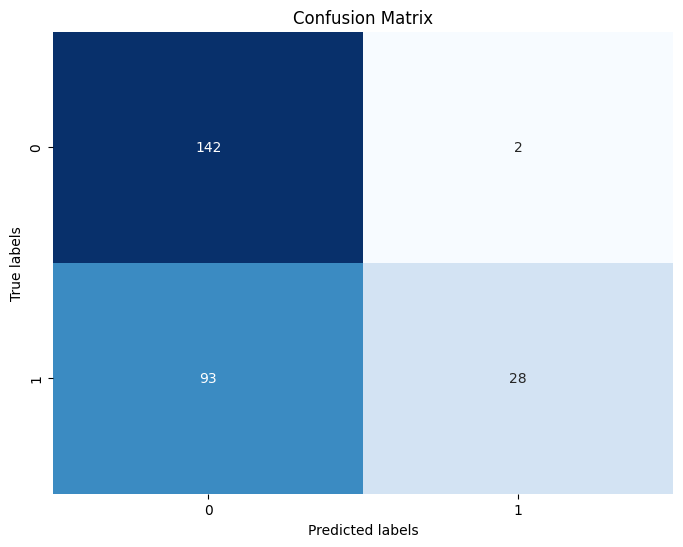

Specificity : 0.9861
Sensitivity : 0.2314
Accuracy : 0.6415
Precision : 0.9333
F1 score : 0.3709
Of 144 people who did not have a prolonged LOS, 142 (98.61%) were correctly classified.
Of 121 people who did have a prolonged LOS, 28 (23.14%) were correctly classified.


In [40]:
plot_cm(model_xgb, X_val_selected, y_val['viz_outcome_prolonged_los_yn'])

In [46]:
y_train = y_train.reset_index()

[0]	validation_0-aucpr:0.71250
[1]	validation_0-aucpr:0.75208
[2]	validation_0-aucpr:0.74042
[3]	validation_0-aucpr:0.75539
[4]	validation_0-aucpr:0.75223
[5]	validation_0-aucpr:0.75581
[6]	validation_0-aucpr:0.75955
[7]	validation_0-aucpr:0.76192
[8]	validation_0-aucpr:0.76200
[9]	validation_0-aucpr:0.76768
[10]	validation_0-aucpr:0.76459
[11]	validation_0-aucpr:0.76525
[12]	validation_0-aucpr:0.74630
[13]	validation_0-aucpr:0.74898
[14]	validation_0-aucpr:0.76234
[15]	validation_0-aucpr:0.76431
[16]	validation_0-aucpr:0.76708
[17]	validation_0-aucpr:0.76106
[18]	validation_0-aucpr:0.76341
[19]	validation_0-aucpr:0.77403
[20]	validation_0-aucpr:0.77208
[21]	validation_0-aucpr:0.76623
[22]	validation_0-aucpr:0.76212
[23]	validation_0-aucpr:0.76170
[24]	validation_0-aucpr:0.76687
[25]	validation_0-aucpr:0.76401
[26]	validation_0-aucpr:0.76818
[27]	validation_0-aucpr:0.76157
[28]	validation_0-aucpr:0.77127
[29]	validation_0-aucpr:0.76731


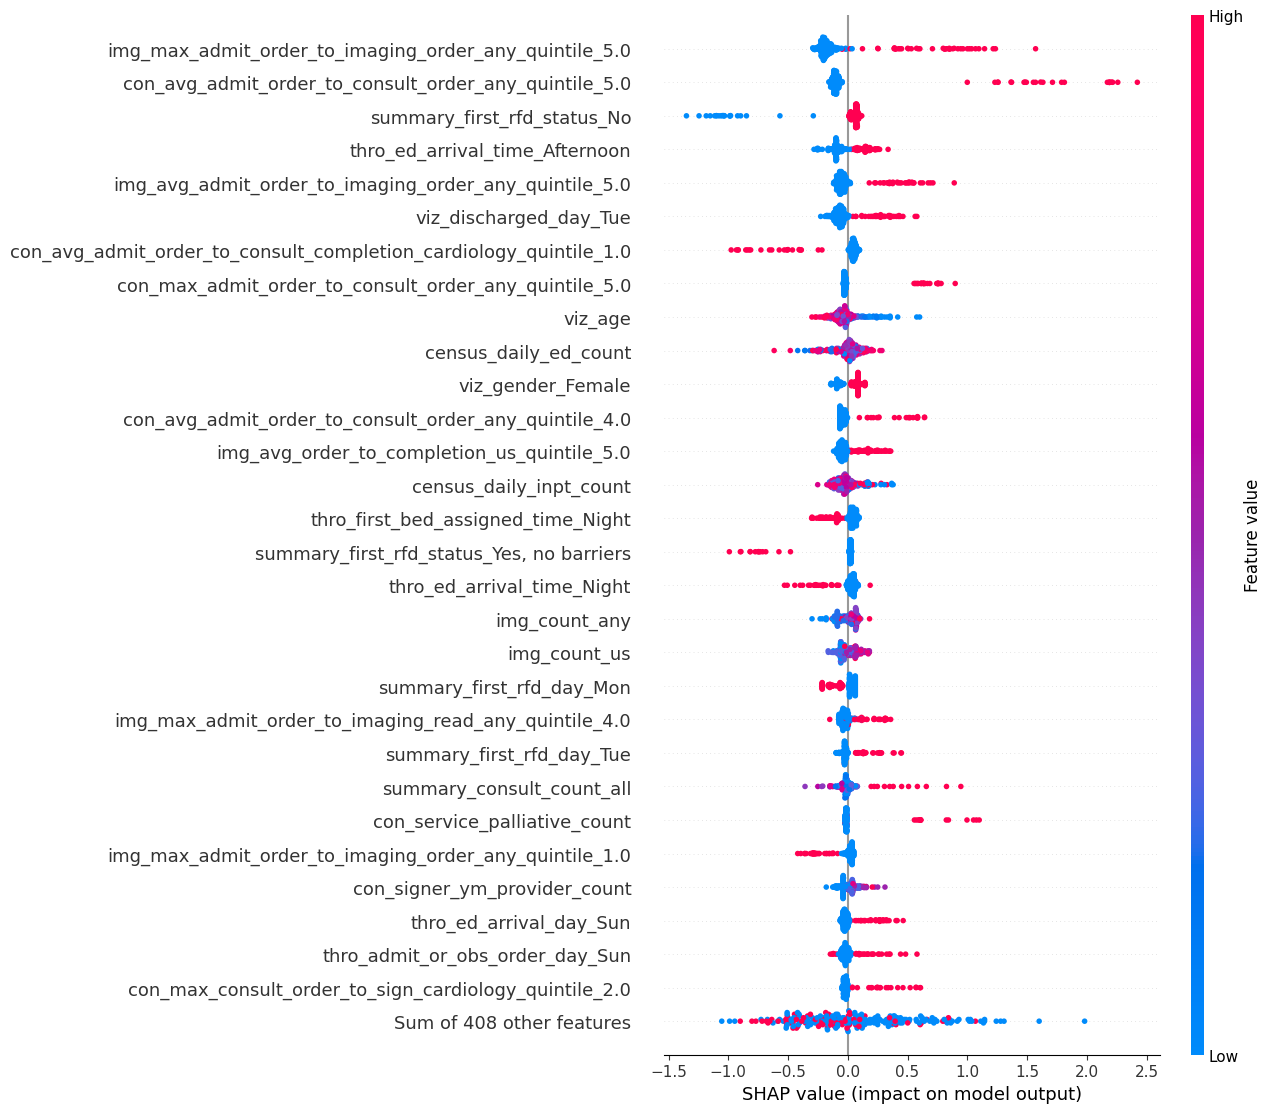

img_max_admit_order_to_imaging_order_any_quintile_5.0
con_avg_admit_order_to_consult_order_any_quintile_5.0
summary_first_rfd_status_No
thro_ed_arrival_time_Afternoon
img_avg_admit_order_to_imaging_order_any_quintile_5.0
viz_discharged_day_Tue
con_avg_admit_order_to_consult_completion_cardiology_quintile_1.0
con_max_admit_order_to_consult_order_any_quintile_5.0
viz_age
census_daily_ed_count
viz_gender_Female
con_avg_admit_order_to_consult_order_any_quintile_4.0
img_avg_order_to_completion_us_quintile_5.0
census_daily_inpt_count
thro_first_bed_assigned_time_Night
summary_first_rfd_status_Yes, no barriers
thro_ed_arrival_time_Night
img_count_any
img_count_us
summary_first_rfd_day_Mon
img_max_admit_order_to_imaging_read_any_quintile_4.0
summary_first_rfd_day_Tue
summary_consult_count_all
con_service_palliative_count
img_max_admit_order_to_imaging_order_any_quintile_1.0
con_signer_ym_provider_count
thro_ed_arrival_day_Sun
thro_admit_or_obs_order_day_Sun
con_max_consult_order_to_sign_cardio

In [50]:
# File paths
train_fp = '/gpfs/milgram/project/rtaylor/imc33/LOS/data/pipeline/los_train_initial_selected.csv'
val_fp = '/gpfs/milgram/project/rtaylor/imc33/LOS/data/pipeline/los_val_initial_selected.csv'

# Save and load data
X_train_selected, X_val_selected = save_load_data(X_train_selected, X_val_selected, train_fp, val_fp)

# Train XGBoost model
clf_xgb = train_xgb_model(X_train_selected, y_train, X_val_selected, y_val)

# Perform SHAP analysis and plot
shap_values = get_shap_plot(clf_xgb, X_val_selected)

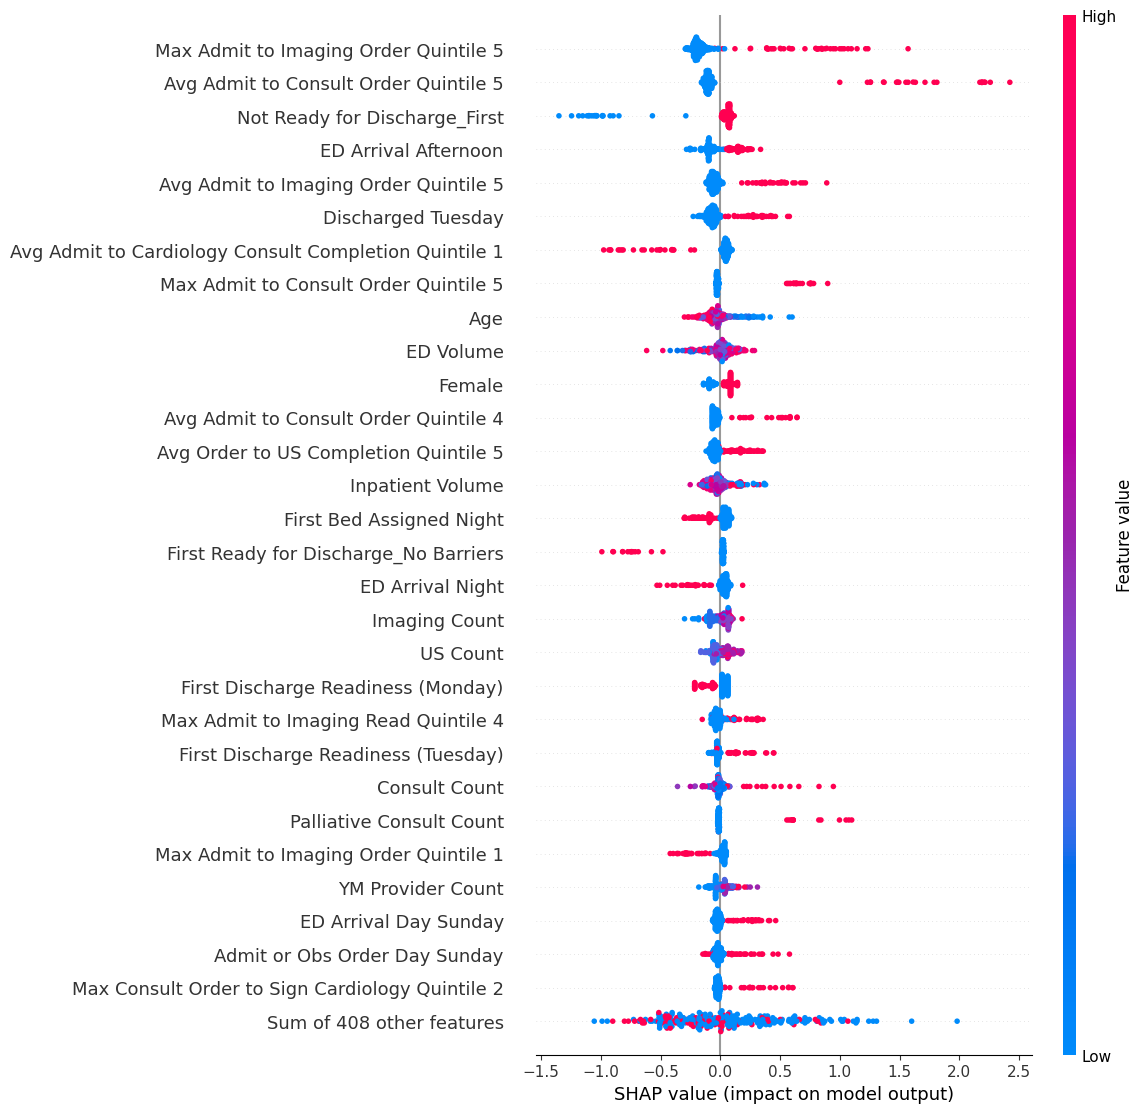

In [52]:
# Example usage
label_names_csv = '/gpfs/milgram/project/rtaylor/imc33/LOS/data/new_label_names.csv'

# Rename SHAP feature names
shap_values_renamed = rename_shap_features(shap_values, label_names_csv)

# Generate the beeswarm plot with the updated feature names
shap.plots.beeswarm(shap_values_renamed, max_display=30)

In [58]:
# Example usage
feature_importance = {
    'viz_ynhhs_sg2_service_Cardiology - Medical': 100,  # Set the importance of 'cardiology_consult'
    # Add other features and their importance levels if needed
}

# Train the XGBoost model with specified feature importance
trained_model = train_xgb_model(X_train_selected, y_train, X_val_selected, y_val, feature_importance)


[0]	validation_0-aucpr:0.71250
[1]	validation_0-aucpr:0.75208
[2]	validation_0-aucpr:0.74042
[3]	validation_0-aucpr:0.75539
[4]	validation_0-aucpr:0.75223
[5]	validation_0-aucpr:0.75581
[6]	validation_0-aucpr:0.75955
[7]	validation_0-aucpr:0.76192
[8]	validation_0-aucpr:0.76200
[9]	validation_0-aucpr:0.76768
[10]	validation_0-aucpr:0.76459
[11]	validation_0-aucpr:0.76525
[12]	validation_0-aucpr:0.74630
[13]	validation_0-aucpr:0.74898
[14]	validation_0-aucpr:0.76234
[15]	validation_0-aucpr:0.76431
[16]	validation_0-aucpr:0.76708
[17]	validation_0-aucpr:0.76106
[18]	validation_0-aucpr:0.76341
[19]	validation_0-aucpr:0.77403
[20]	validation_0-aucpr:0.77208
[21]	validation_0-aucpr:0.76623
[22]	validation_0-aucpr:0.76212
[23]	validation_0-aucpr:0.76170
[24]	validation_0-aucpr:0.76687
[25]	validation_0-aucpr:0.76401
[26]	validation_0-aucpr:0.76818
[27]	validation_0-aucpr:0.76157
[28]	validation_0-aucpr:0.77127


In [60]:
explainer = shap.Explainer(trained_model)
shap_values = explainer(X_val_selected)

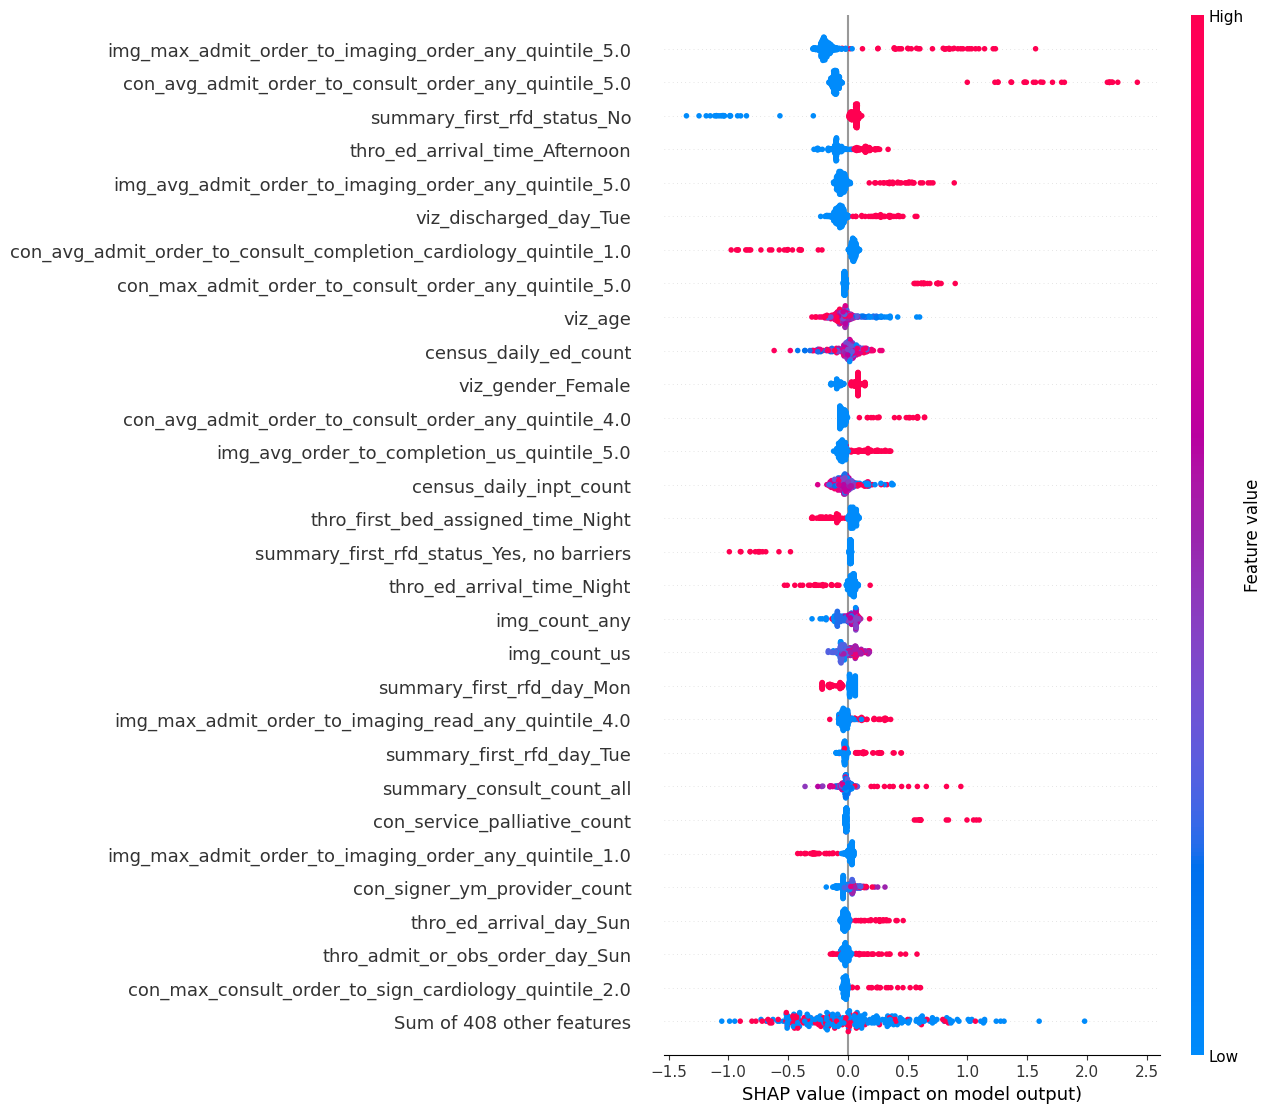

In [61]:
# Plot SHAP values
shap.plots.beeswarm(shap_values, max_display=30)

plt.show()

In [64]:
shap_values_df

,viz_age,thro_boarding_yn,summary_consult_count_all,summary_consult_count_unique_services,con_signer_ym_provider_count,con_signer_nemg_provider_count,con_signer_community_provider_count,con_service_addiction_medicine_count,con_service_cardiology_count,con_service_diabetes_count,...,con_unique_services_which2_Rare,con_unique_services_which2_Cardiology,con_unique_services_which2_Missing,con_unique_services_which2_Multiple,con_unique_services_which2_Pharmacy,con_unique_services_which2_Nephrology,con_unique_services_which2_Pulmonology,con_unique_services_which2_Palliative,con_unique_services_which2_Diabetes,viz_gender_Female
0,-0.000470,-0.014148,0.043924,0.005194,-0.119409,0.0,0.003002,0.0,-0.001882,0.0,...,0.017191,0.0,0.0,0.0,0.0,0.011485,0.0,0.0,0.0,-0.092559
1,0.027611,0.019282,0.074342,0.007767,0.130689,0.0,0.008582,0.0,-0.001685,0.0,...,-0.048777,0.0,0.0,0.0,0.0,0.004556,0.0,0.0,0.0,-0.049978
2,-0.030967,0.007219,0.011621,0.002599,0.037123,0.0,0.005302,0.0,0.006720,0.0,...,0.004340,0.0,0.0,0.0,0.0,0.005944,0.0,0.0,0.0,0.068721
3,-0.030930,0.007054,-0.015093,-0.000756,-0.036550,0.0,0.000808,0.0,-0.002678,0.0,...,0.002344,0.0,0.0,0.0,0.0,0.013158,0.0,0.0,0.0,0.116918
4,-0.039863,-0.009180,-0.150582,-0.006092,0.046875,0.0,0.001829,0.0,0.000464,0.0,...,0.017191,0.0,0.0,0.0,0.0,0.000802,0.0,0.0,0.0,-0.089905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,0.051942,0.008473,-0.016897,-0.001948,-0.037761,0.0,0.003980,0.0,-0.000560,0.0,...,0.002344,0.0,0.0,0.0,0.0,0.006304,0.0,0.0,0.0,0.085548
261,-0.009759,0.004485,-0.016659,-0.000761,-0.034392,0.0,0.002102,0.0,-0.002405,0.0,...,0.002344,0.0,0.0,0.0,0.0,0.012631,0.0,0.0,0.0,0.085548
262,0.209755,0.005658,-0.014009,-0.001734,-0.040093,0.0,0.001991,0.0,-0.001518,0.0,...,0.002344,0.0,0.0,0.0,0.0,0.015581,0.0,0.0,0.0,0.068721
263,-0.076371,0.012371,-0.018279,-0.000756,-0.040093,0.0,0.000412,0.0,-0.002405,0.0,...,0.004340,0.0,0.0,0.0,0.0,0.013158,0.0,0.0,0.0,0.085548
